**COS 485 Final Project**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# import libraries
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from torchvision.transforms import ToTensor
from IPython import display

In [0]:
# Extracts tilt and pan angles from image filenames
def extractAngles(filename):
    if filename[13] in ['+','-']:
      tilt = 0
      if filename[15] == '.':
        pan = 0
      else:
        pan = int(filename[13:16])
    else:
      tilt = int(filename[11:14])
      if filename[16] == '.':
        pan = 0
      else:
        pan = int(filename[14:17])
    return tilt, pan
    

In [0]:
def plot_image(image):
    nr, nc = image.shape
    extent = [-0.5, nc - 0.5, nr - 0.5, -0.5]
    plt.imshow(image, extent=extent, origin='upper', interpolation='nearest')

def visualize(t_train, t_val, loss_train, loss_val):
    loss_train = np.array(torch.Tensor(loss_train).cpu())
    loss_val = np.array(torch.Tensor(loss_val).cpu())

    loss_train_avg = np.divide(
        np.cumsum(loss_train[: t_train + 1]),
        range(1, t_train + 2)
    )

    loss_val_avg = np.divide(
        np.cumsum(loss_val[: t_val + 1]),
        range(1, t_val + 2)
    )

    n_train_last_batches = np.min([20, t_train])
    k_train = np.ones(n_train_last_batches * 2 + 1) / (n_train_last_batches + 1)
    k_train[:n_train_last_batches] = 0
    
    n_val_last_batches = np.min([20, t_val])
    k_val = np.ones(n_val_last_batches * 2 + 1) / (n_val_last_batches + 1)
    k_val[:n_val_last_batches] = 0

   
    loss_train_sm = np.convolve(np.pad(loss_train, mode="edge", pad_width=n_train_last_batches), k_train, mode="valid")
    loss_train_sm = loss_train_sm[: len(loss_train)]
    loss_val_sm = np.convolve(np.pad(loss_val, mode="edge", pad_width=n_val_last_batches), k_val, mode="valid")
    loss_val_sm = loss_val_sm[: len(loss_val)]

    display.clear_output(wait=True)
    
    plt.subplot(1, 2, 1)
    plt.plot(loss_train, label="train loss")
    plt.plot(loss_train_sm, label="train smoothed loss")
    plt.plot(loss_train_avg, label="train avg loss")
    plt.legend()
    plt.ylim(0, np.max(loss_train)*1.05)
    plt.title("train loss: avg - %.4f, smoothed - %.4f, current - %.4f"  % (loss_train_avg[t_train], loss_train_sm[t_train], loss_train[t_train]))

   
    plt.subplot(1, 2, 2)
    plt.plot(loss_val, label="val. loss")
    plt.plot(loss_val_sm, label="val. smoothed loss")
    plt.plot(loss_val_avg, label="val. avg loss")
    plt.legend()
    plt.ylim(0, np.max(loss_val)*1.05)
    plt.title("val. loss: avg - %.4f, smoothed - %.4f, current - %.4f"  % (loss_val_avg[t_val], loss_val_sm[t_val], loss_val[t_val]))

    
    plt.subplots_adjust(wspace=0.5)
    plt.subplots_adjust(hspace=0.5)
    plt.gcf().set_size_inches(18, 9)
    display.display(plt.gcf())

In [0]:
file_dir = "drive/My Drive/COS 485/Final Project/"

In [0]:
#######################################################################
# Run to Save Data
#######################################################################
data = []
tilt = []
pan = []
local_download_path = file_dir + "Images_All"
for filename in os.listdir(local_download_path):
    if filename.endswith("jpg"): 
        # Your code comes here such as 
        image = Image.open(local_download_path + '/' + filename)
        image = ToTensor()(image).unsqueeze(0) # unsqueeze to add artificial first dimension
        # image = Variable(image)
        data.append(image)
        tiltAngle, panAngle = extractAngles(filename)
        pan.append(panAngle)
        tilt.append(tiltAngle)

dataToSave = torch.stack(data).numpy() #saved as 'arr_0'
tiltToSave = torch.tensor(tilt).numpy() #saved as 'arr_1'
panToSave = torch.tensor(pan).numpy() #saved as 'arr_2'

np.savez(file_dir + "headImageData.npz", dataToSave, tiltToSave, panToSave)

In [0]:
#######################################################################
# Run to Retrieve Data
#######################################################################
full_data = np.load(file_dir + "headImageData.npz")
all_data = {
    "train": torch.tensor(full_data["arr_0"][:2490]), 
    "val": torch.tensor(full_data["arr_0"][2490:])
    }
all_tilt = {
    "train": torch.tensor(full_data["arr_1"][:2490]), 
    "val": torch.tensor(full_data["arr_1"][2490:])
    }

In [0]:
model_name = "resnet" # either resnet or vgg
num_classes = 9
batch_size = 30
num_epochs = 30
feature_extract = False # true for feature extraction; false for finetuning

In [0]:
def get_label(i, num_classes):
    """return label for i'th training example"""

    tilt = full_data["arr_1"]
    if tilt[i] == -90:
      return 0
    
    elif tilt[i] == -60:
      if num_classes == 9:
        return 1
      return 0

    elif tilt[i] == -30:
      if num_classes == 9:
        return 2
      if num_classes == 3:
        return 1
      return 0

    elif tilt[i] == -15:
      if num_classes == 9:
        return 3
      if num_classes == 3:
        return 1
      return 1

    elif tilt[i] == 0:
      if num_classes == 9:
        return 4
      if num_classes == 3:
        return 2
      return 1
    
    elif tilt[i] == 15:
      if num_classes == 9:
        return 5
      if num_classes == 3:
        return 3
      return 1

    elif tilt[i] == 30:
      if num_classes == 9:
        return 6
      if num_classes == 3:
        return 3
      return 2

    elif tilt[i] == 60:
      if num_classes == 9:
        return 7
      if num_classes == 3:
        return 4
      return 2

    else: # tilt[i] = 90
      if num_classes == 9:
        return 8
      if num_classes == 3:
        return 4
      return 2

In [0]:
new_tilt = {
    "train": [], 
    "val": []
    }

for i in range(len(all_tilt["train"])):
  new_tilt["train"].append(get_label(i, num_classes))
  
for i in range(len(all_tilt["val"])):
  new_tilt["val"].append(get_label(i + len(all_tilt["train"]), num_classes))

tilt = {}
tilt["train"] = torch.Tensor(new_tilt["train"])
tilt["val"] = torch.Tensor(new_tilt["val"])

In [0]:
accuracy = {'train': [], 'val': []} # store accuracies after every epoch

def train_model(model, criterion, optimizer, num_epochs=30):
    since = time.time()
    disp_freq = 10
    t = 0
    val_acc_history = []
    val_loss_history = []

    errs_train = []
    losses_train = []

    errs_val = []
    losses_val = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            data = all_data[phase]
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            for i in range(len(data) // batch_size):
                batch_indices = np.random.choice(len(data), batch_size, replace=False)

                inputs = (data[batch_indices].float() / 255).view(batch_size, 3, 288, 384)

                labels = torch.zeros([batch_size], dtype=torch.long)
                for i in range(len(batch_indices)):
                  labels[i] = tilt[phase][batch_indices[i]]

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                if t % 1 == 0:
                  if phase == 'train':
                    losses_train.append(loss.item() * inputs.size(0))
                    errs_train.append(torch.sum(preds != labels.data) / batch_size)
                  elif phase == 'val':
                    losses_val.append(loss.item() * inputs.size(0))
                    errs_val.append(torch.sum(preds != labels.data) / batch_size)
                t+=1
                
                if len(errs_val)>1:
                  plt.gcf().clear()
                  visualize(len(errs_train) - 1, len(errs_val) - 1, losses_train, losses_val)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                
            epoch_loss = running_loss / len(tilt[phase])
            epoch_acc = running_corrects.double() / len(tilt[phase])

            accuracy[phase].append(epoch_acc)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [12]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

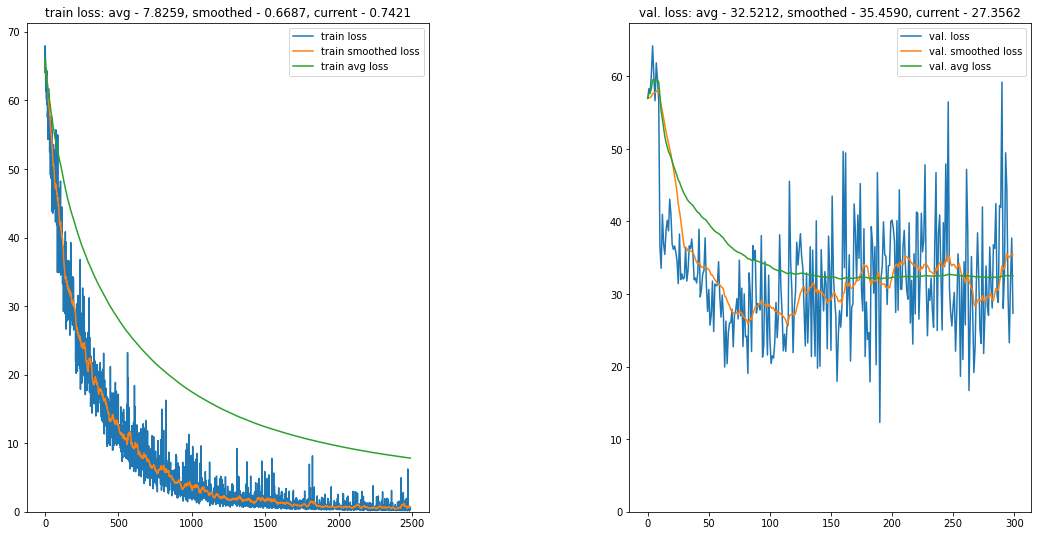

val Loss: 1.2115 Acc: 0.6133
Training complete in 27m 38s
Best val Acc: 0.693333


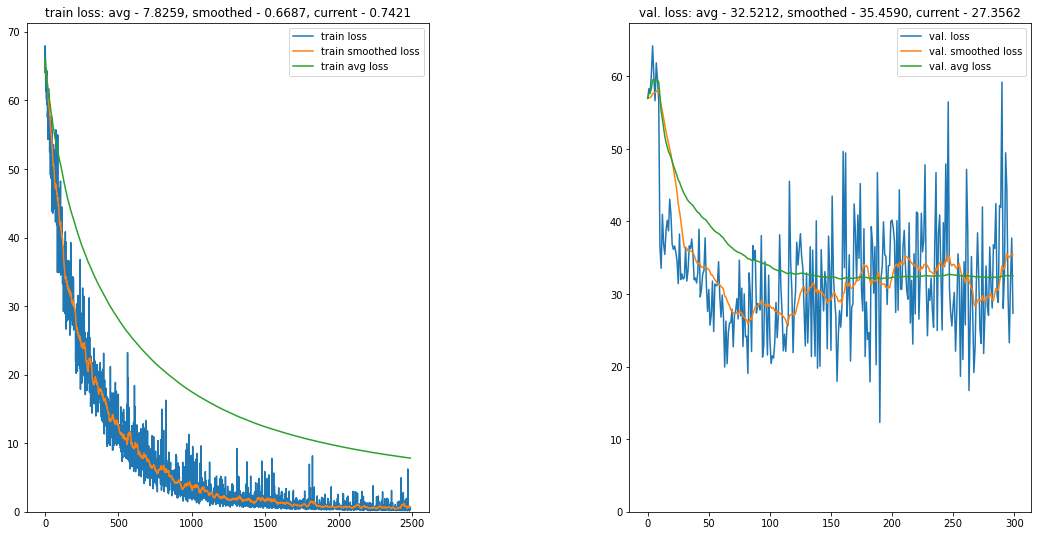

In [13]:
# Send the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters() # parameters to update

if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)


# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0005, momentum=0.9)


# Setup the loss function
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, criterion, optimizer_ft, num_epochs=num_epochs)

Text(0.5, 1.0, 'Accuracy vs Num Epochs')

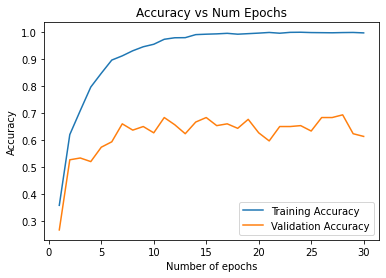

In [14]:
plt.plot(range(1, 31), accuracy['train'])
plt.plot(range(1, 31), accuracy['val'])
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.title('Accuracy vs Num Epochs')